# In this example, we will learn training from scratch.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
##First build a smaller dataset
from_dir="train/"
to_dir="small_train/"
all_files=os.listdir(from_dir)
cat_files=[f for f in all_files if f[:3]=="cat"]
dog_files=[f for f in all_files if f[:3]=="dog"]

np.random.shuffle(cat_files)
np.random.shuffle(dog_files)

def mkdir_(dir_):
    if not os.path.exists(dir_):
        os.makedirs(dir_)    
train_cats=cat_files[:1000];mkdir_(os.path.join(to_dir,"train","cats"))
train_dogs=dog_files[:1000];mkdir_(os.path.join(to_dir,"train","dogs"))
val_cats=cat_files[1000:1500];mkdir_(os.path.join(to_dir,"val","cats"))
val_dogs=dog_files[1000:1500];mkdir_(os.path.join(to_dir,"val","dogs"))
test_cats=cat_files[1500:2000];mkdir_(os.path.join(to_dir,"test","cats"))
test_dogs=dog_files[1500:2000];mkdir_(os.path.join(to_dir,"test","dogs"))

def copy(choosen_cats,choosen_dogs,k):
    for c,d in tqdm(zip(choosen_cats,choosen_dogs)):
        shutil.copy(os.path.join(from_dir,c),os.path.join(to_dir,k,"cats",c))
        shutil.copy(os.path.join(from_dir,d),os.path.join(to_dir,k,"dogs",d))
        if not os.path.exists(os.path.join(to_dir,k,"cats",c)):
            print(c+"Copy Failed!")
        if not os.path.exists(os.path.join(to_dir,k,"dogs",d)):
            print(d+"Copy Failed!")
copy(train_cats,train_dogs,"train")
copy(val_cats,val_dogs,"val")
copy(test_cats,test_dogs,"test")

1000it [00:38, 25.77it/s]
500it [00:20, 24.53it/s]
500it [00:20, 24.02it/s]


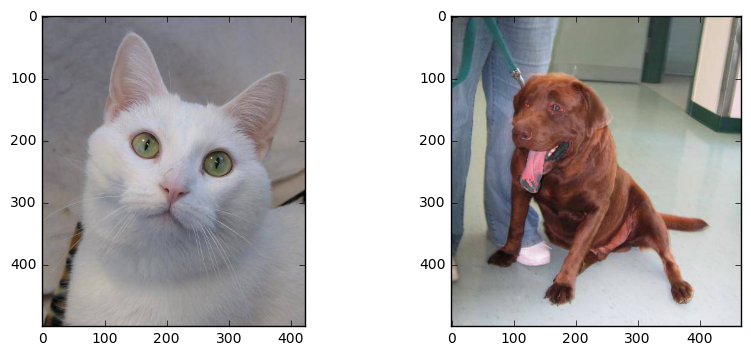

In [2]:
%matplotlib inline
from PIL import Image
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(Image.open(os.path.join(to_dir,"train","cats",train_cats[0])))
fig.add_subplot(122)
plt.imshow(Image.open(os.path.join(to_dir,"train","dogs",train_dogs[0])))
plt.show()

train_dir=os.path.join(to_dir,"train")
val_dir=os.path.join(to_dir,"val")
test_dir=os.path.join(to_dir,"test")

# Next,we need to do the preprocessing.
 First, read from directory and transform into array.
 Second, divede by 255.
 Third, resize them.
## Thankfully, Keras has function to do these for us.

In [36]:
from keras.preprocessing.image import ImageDataGenerator
##Adding Data Augmentation to prevent overfitting
train_gen=ImageDataGenerator(rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
val_gen=ImageDataGenerator(rescale=1./255)
##Generate data from directory
train_gener=train_gen.flow_from_directory(
            train_dir,#assign the training dir
            target_size=(150,150),
            batch_size=20,
            class_mode="binary"
            )
val_gener=val_gen.flow_from_directory(
            val_dir,
            target_size=(150,150),
            batch_size=20,
            class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Define our network(4 conv+2 dense)

In [37]:
from keras import models
from keras import layers

model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))##0.5 is the rate to drop, not keep
model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [38]:
model.compile(loss="binary_crossentropy",
             optimizer="rmsprop",
             metrics=["acc"])

# Train model

In [41]:
history=model.fit_generator(
        train_gener,
        steps_per_epoch=100,
        epochs=100,
        validation_data=val_gener,
        validation_steps=50)

Epoch 1/100
100/100 [==============================] - 13s 128ms/step - loss: 0.5617 - acc: 0.7230 - val_loss: 0.5216 - val_acc: 0.7390
Epoch 2/100
100/100 [==============================] - 11s 114ms/step - loss: 0.5592 - acc: 0.7150 - val_loss: 0.5090 - val_acc: 0.7700
Epoch 3/100
100/100 [==============================] - 12s 116ms/step - loss: 0.5395 - acc: 0.7475 - val_loss: 0.5060 - val_acc: 0.7600
Epoch 4/100
100/100 [==============================] - 12s 116ms/step - loss: 0.5529 - acc: 0.7305 - val_loss: 0.5566 - val_acc: 0.7110
Epoch 5/100
100/100 [==============================] - 12s 117ms/step - loss: 0.5367 - acc: 0.7325 - val_loss: 0.4859 - val_acc: 0.7850
Epoch 6/100
100/100 [==============================] - 11s 115ms/step - loss: 0.5347 - acc: 0.7420 - val_loss: 0.4569 - val_acc: 0.8080
Epoch 7/100
100/100 [==============================] - 12s 117ms/step - loss: 0.5444 - acc: 0.7380 - val_loss: 0.4710 - val_acc: 0.7830
Epoch 8/100
100/100 [===========================

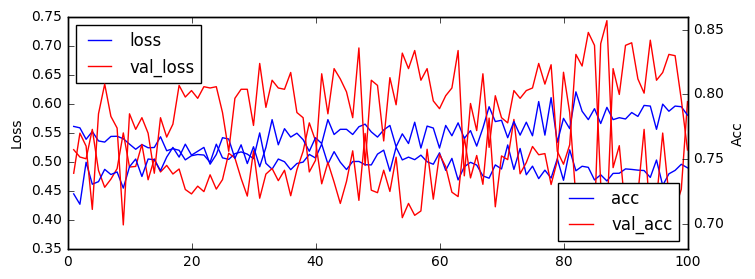

In [44]:
loss=history.history["loss"];val_loss=history.history["val_loss"]
acc=history.history["acc"];val_acc=history.history["val_acc"]
epochs=np.arange(1,101)
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(8,3))
ax1=fig.add_subplot(111)
ax1.plot(epochs,loss,"b",label="loss")
ax1.plot(epochs,val_loss,"r",label="val_loss")
ax1.set_ylabel("Loss")
ax1.legend(loc="best")
ax2=ax1.twinx()
ax2.plot(epochs,acc,"b",label="acc")
ax2.plot(epochs,val_acc,"r",label="val_acc")
ax2.set_ylabel("Acc")
ax2.legend(loc="lower right")
plt.show()

# Finally, got a model(loss: 0.6043, acc: 0.7570)

In [46]:
model.evaluate_generator(val_gener)

[0.60429348289966578, 0.75700000286102298]

In [47]:
model.save("cats_and_dogs_small.h5")